In [7]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-26
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

from Function.snn_IZHIlayers import *
from Function.snn_plot import *
from Function.snn_simulation import *
from Function.snn_stimulation import *
from Function.snn_receptive_field_weights import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(f"Using device: {device}")\

# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPU available: False
CUDA version: None
Using device: cpu


[1.5707963267948966]
torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_rf shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_rf shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_rf shape:  torch.Size([54, 54])
ra_intopn_rf shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([28, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([28, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([28, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([28, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn

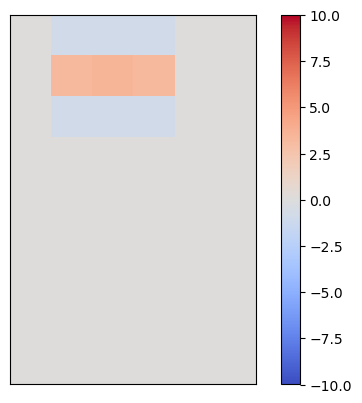

tensor(5.0000)


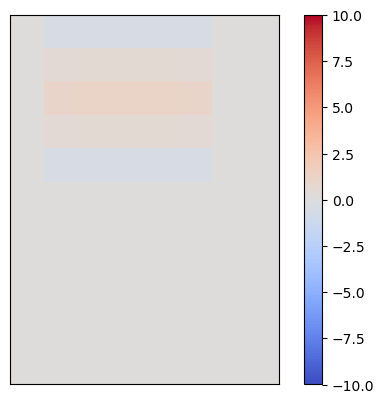

tensor(5.0000)


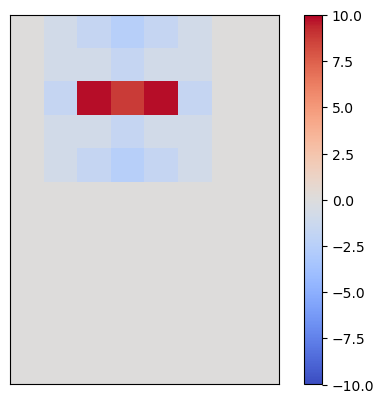

tensor(-6.9618e-05)


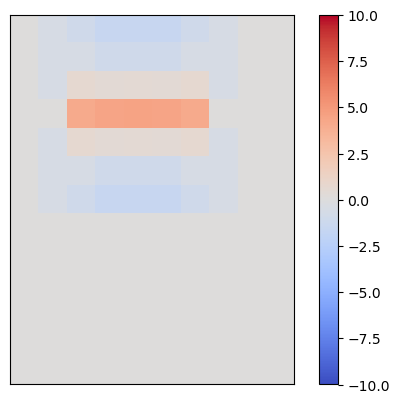

tensor(4.7684e-06)


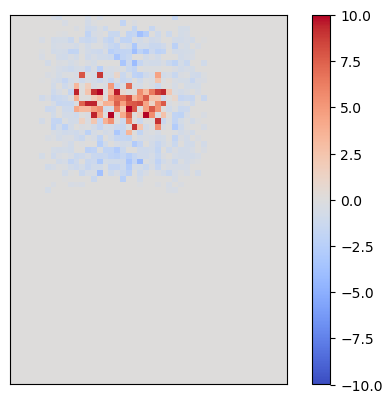

tensor(-32.2290) tensor(-5.7006)


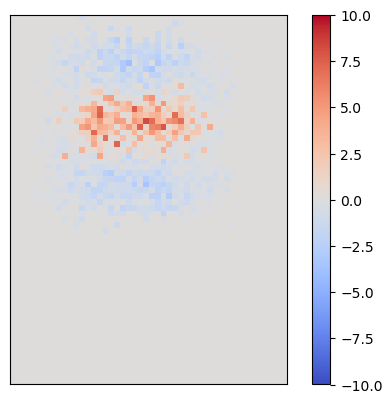

tensor(-32.2290) tensor(-5.7006)


In [8]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device, type_output = [np.pi/2], plot_receptive_field = True,plot_ind = 1)

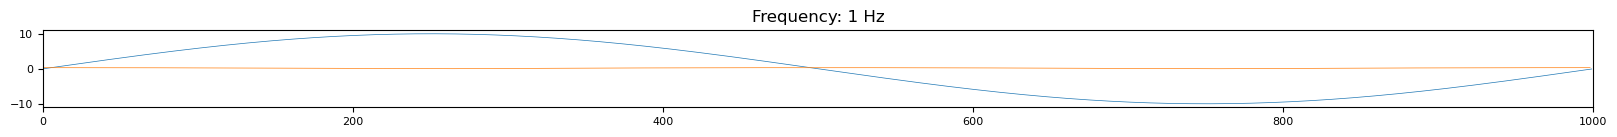

In [13]:
stim = generate_single_frequency_stimulation(1, num_stim=1000, pixel_h=pixel_h, pixel_w=pixel_w, F=10, plot_stimuli = True ,device=device)

recording_stimulation(stim,filename = 'Frequency1.gif')

Trials:   0%|          | 0/1 [00:00<?, ?it/s]

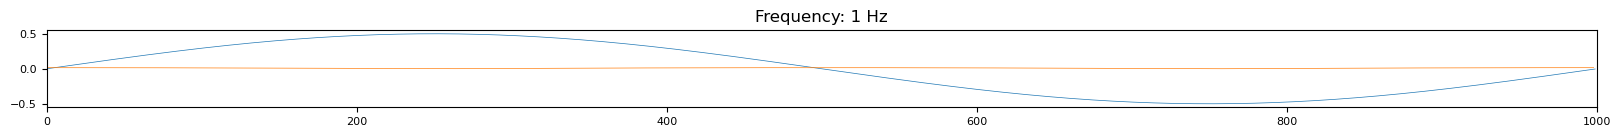

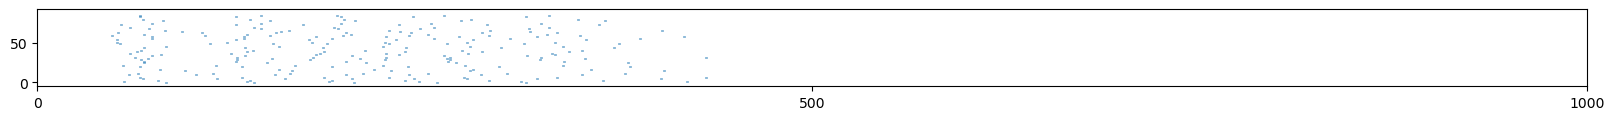

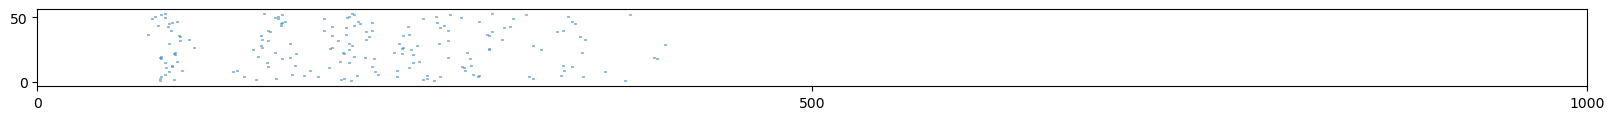

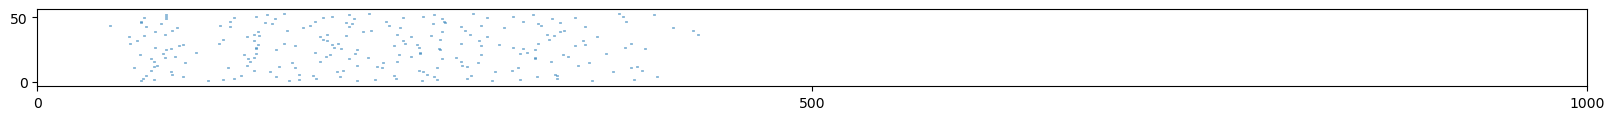

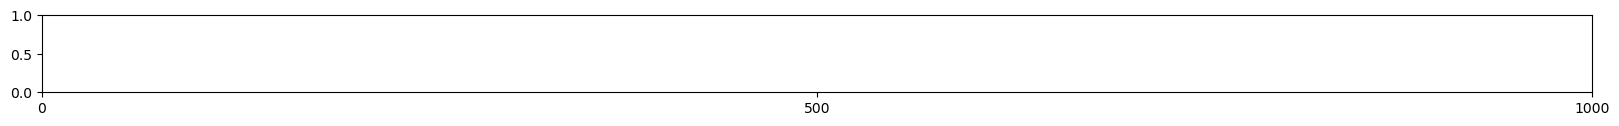

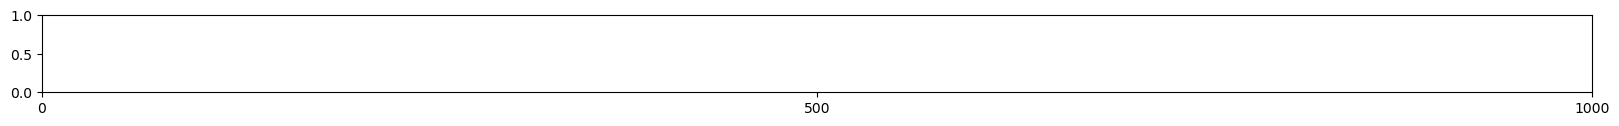

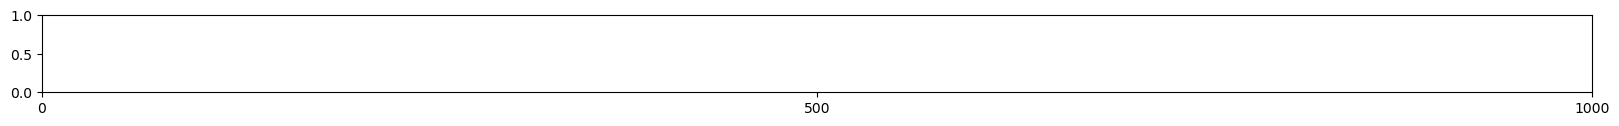

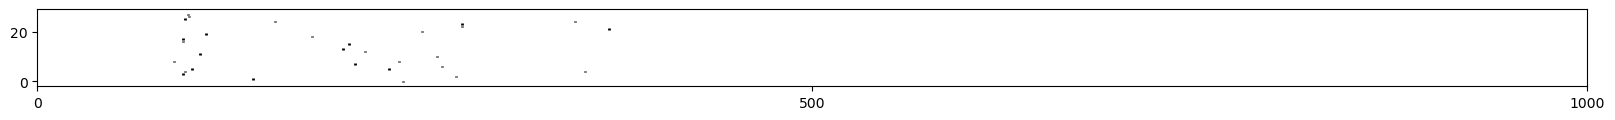

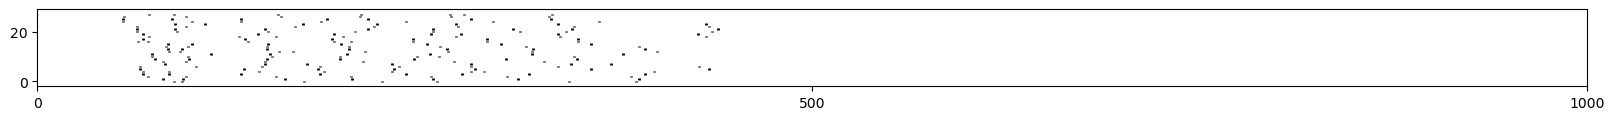

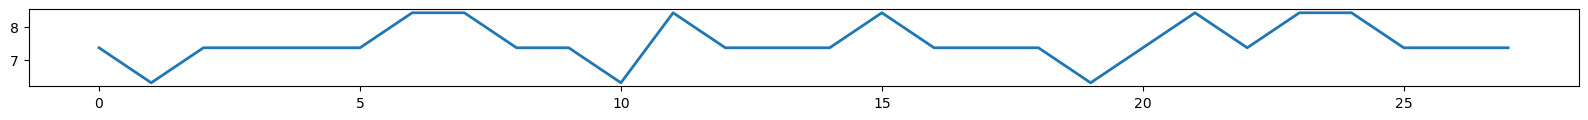

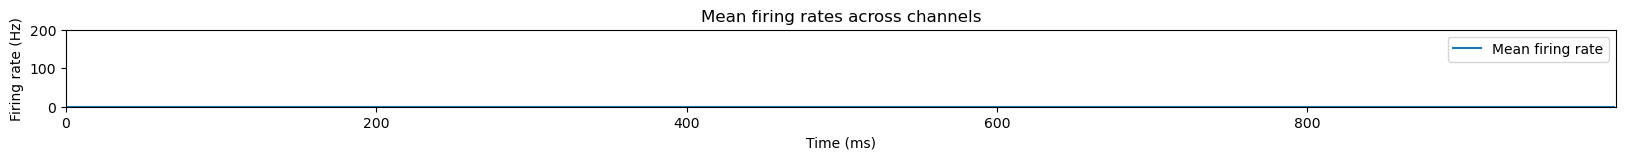

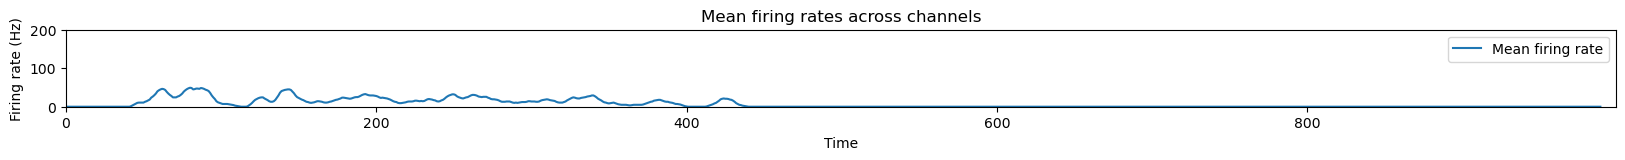

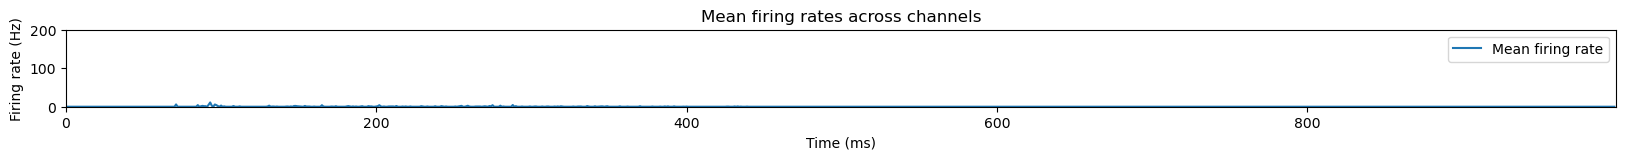

frequency:1 Hz    Mean Firing Rate(Hz): 7.518797397613525


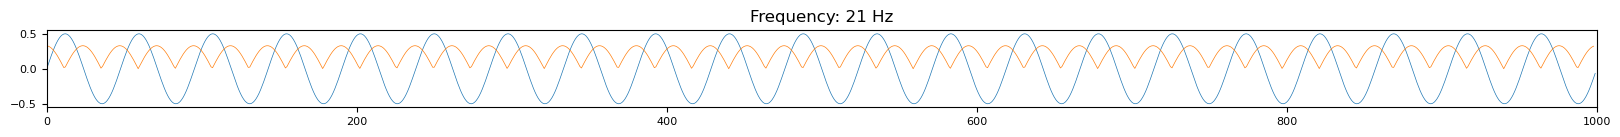

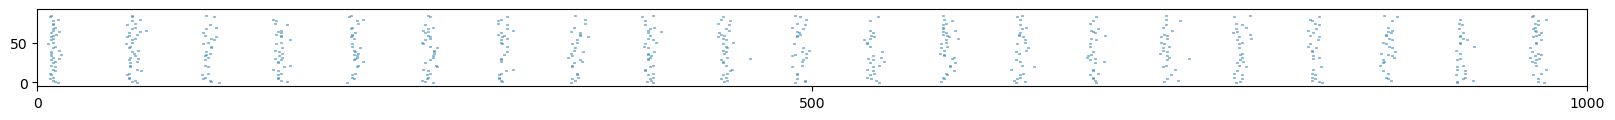

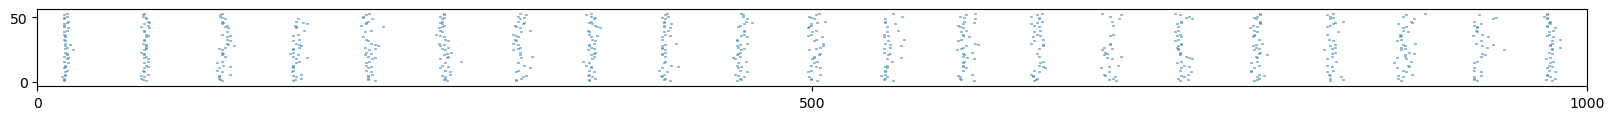

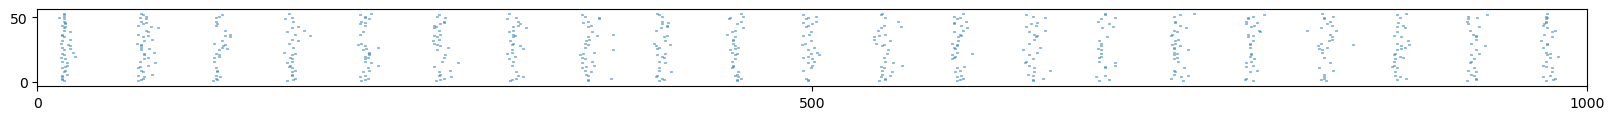

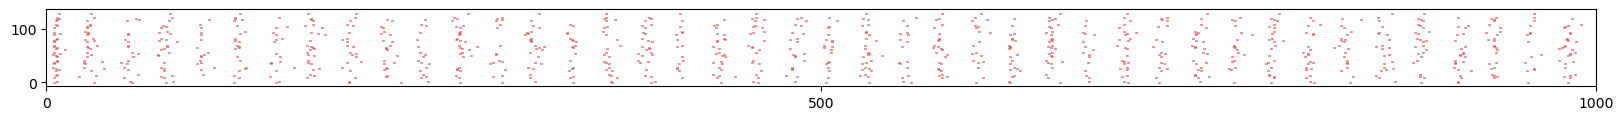

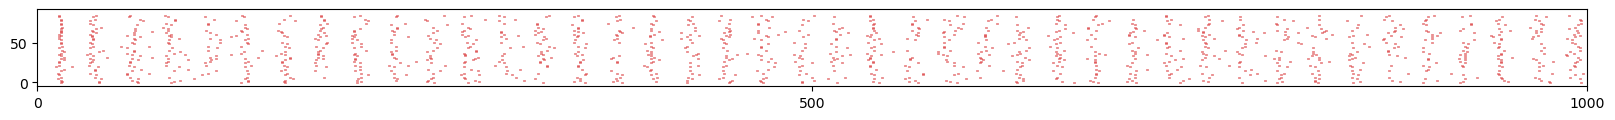

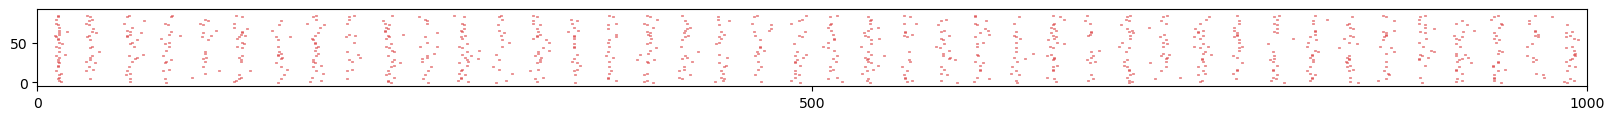

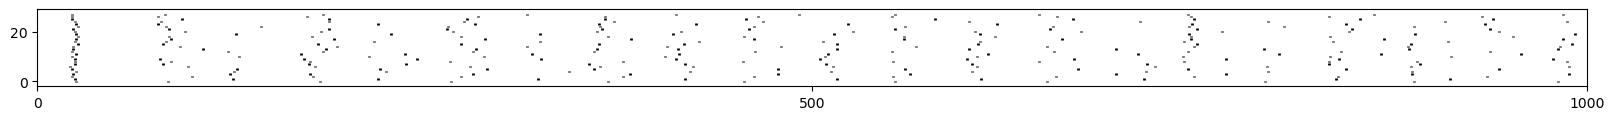

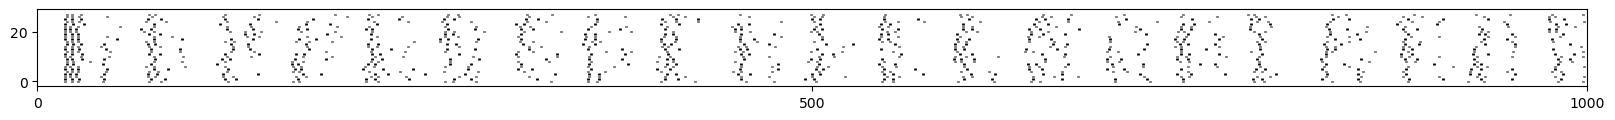

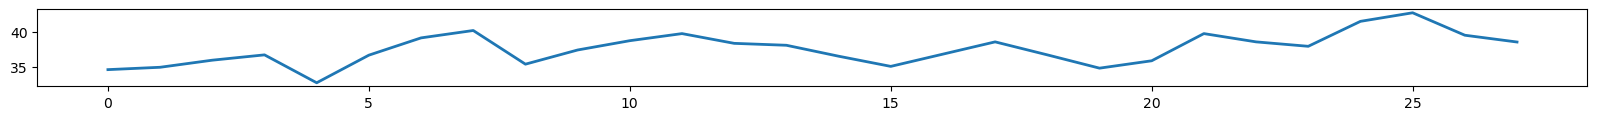

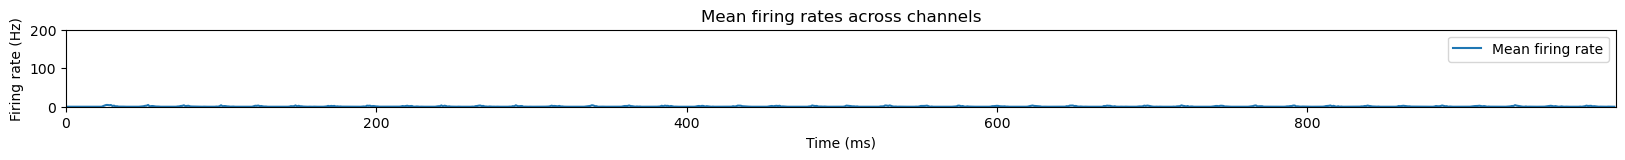

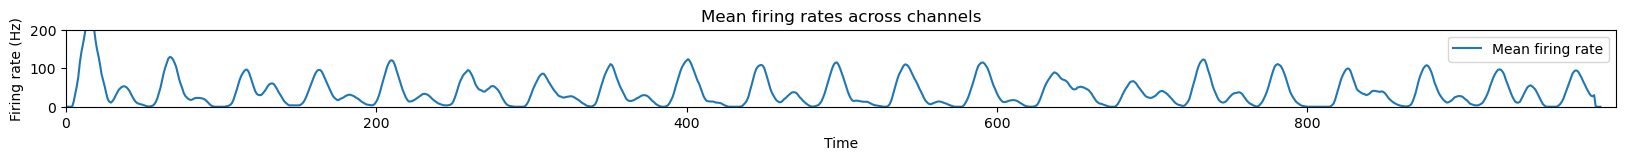

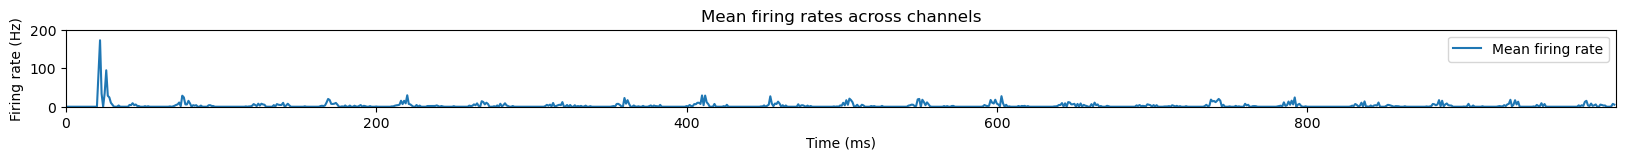

frequency:21 Hz    Mean Firing Rate(Hz): 37.578948974609375


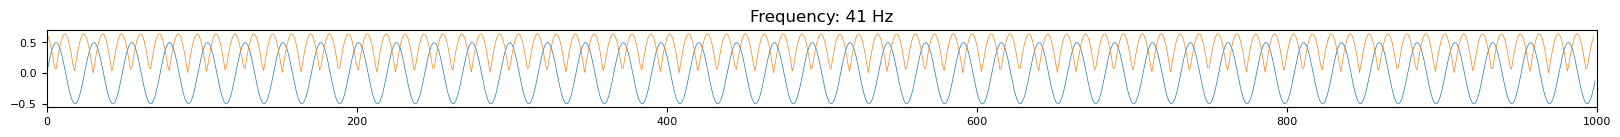

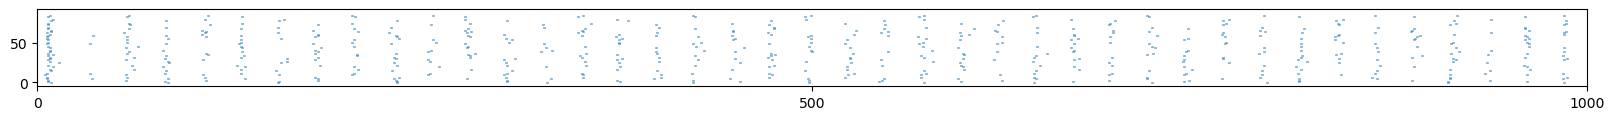

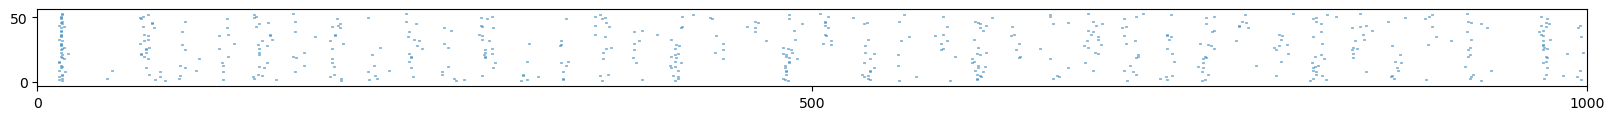

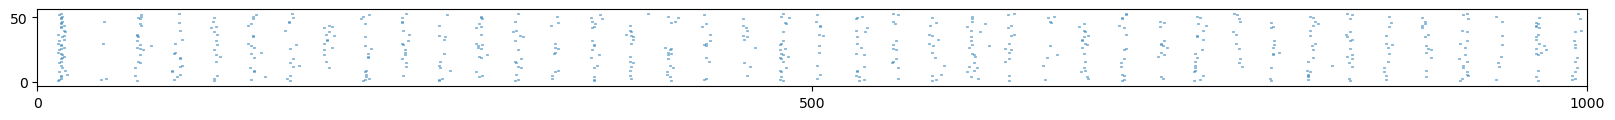

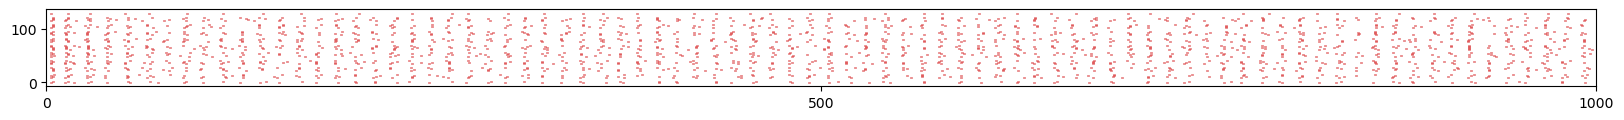

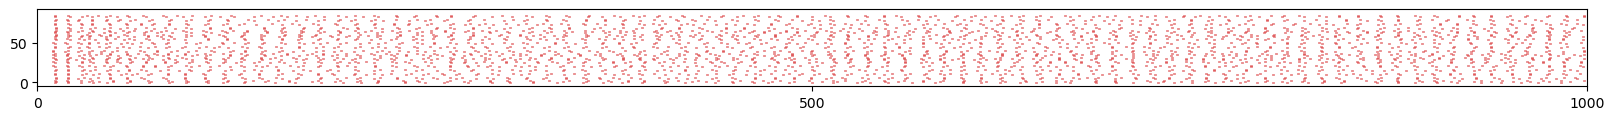

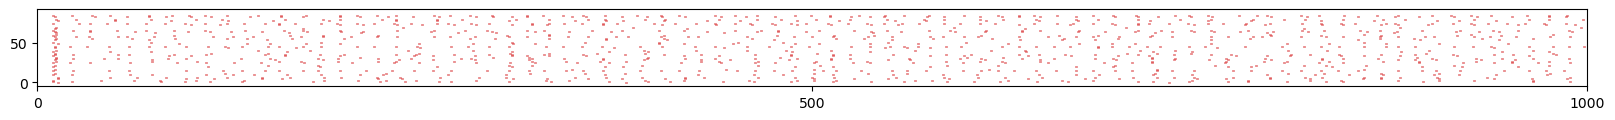

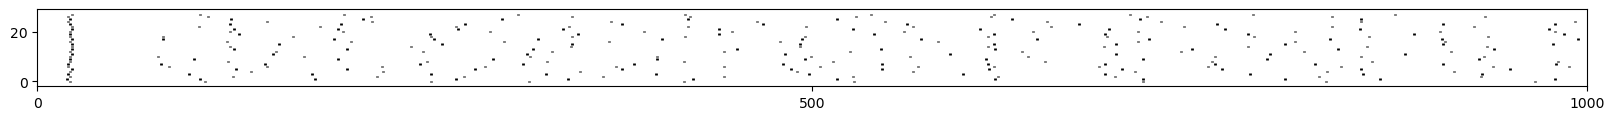

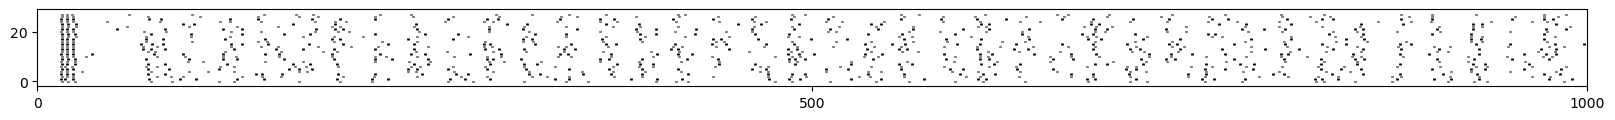

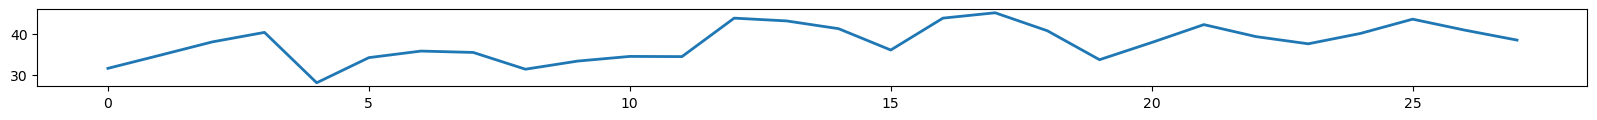

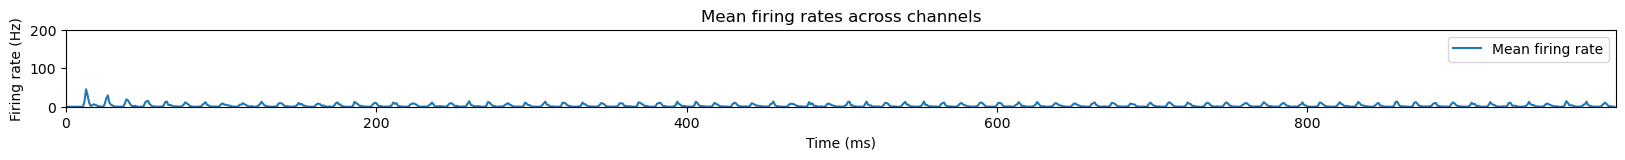

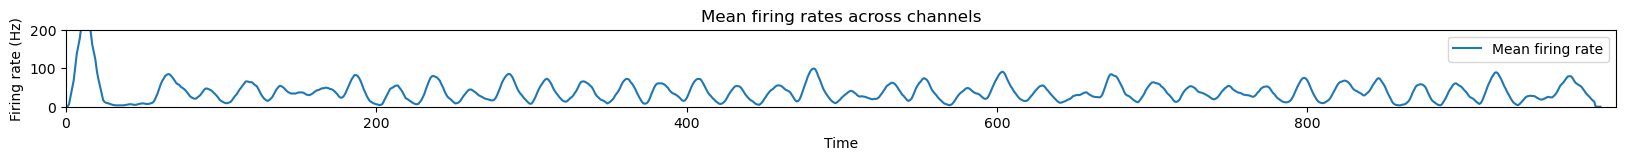

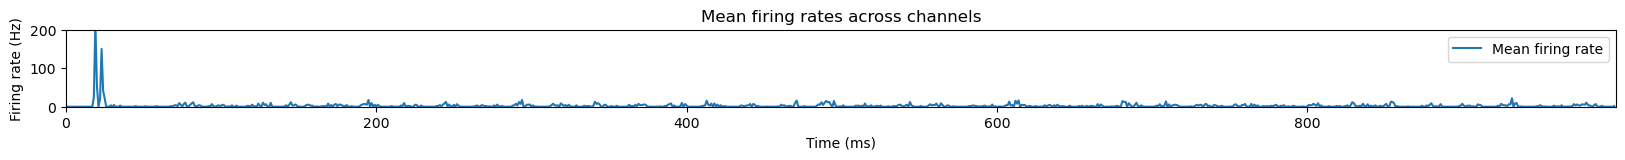

frequency:41 Hz    Mean Firing Rate(Hz): 37.8353385925293


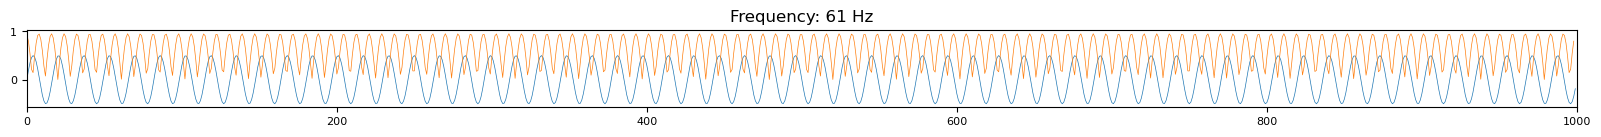

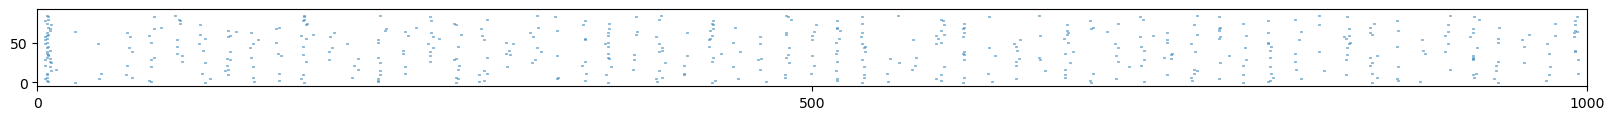

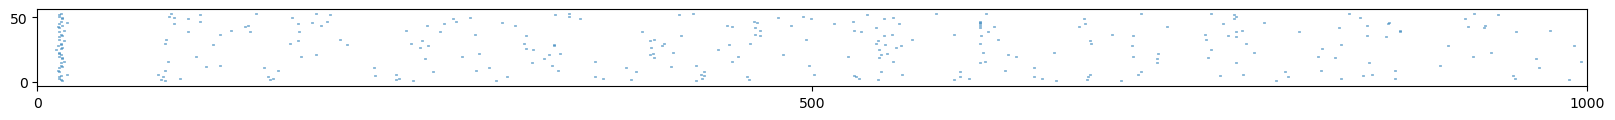

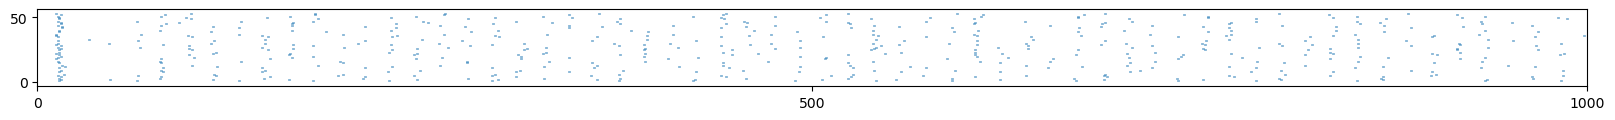

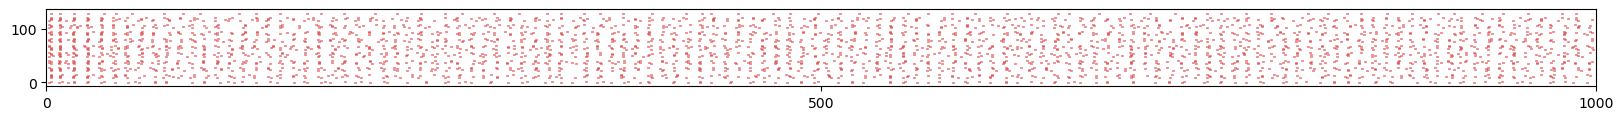

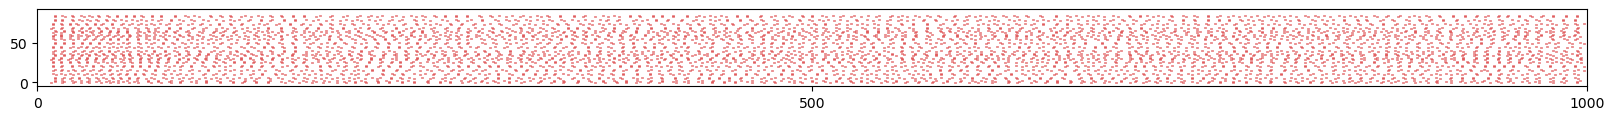

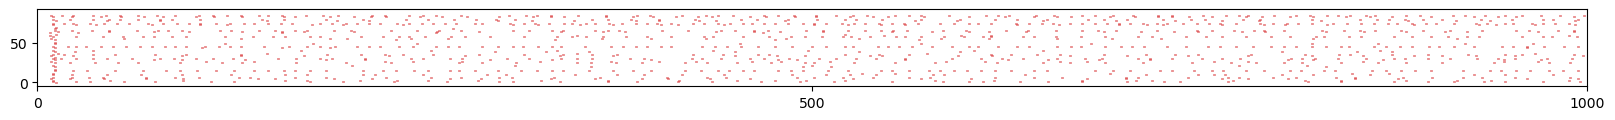

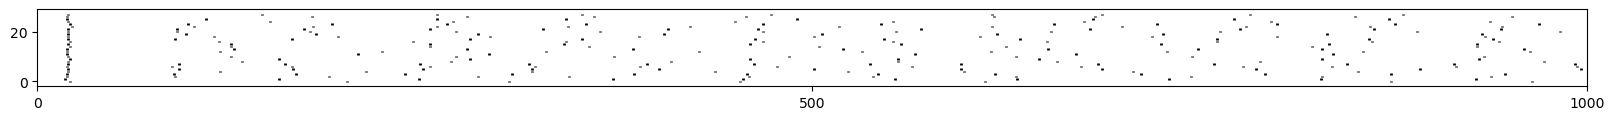

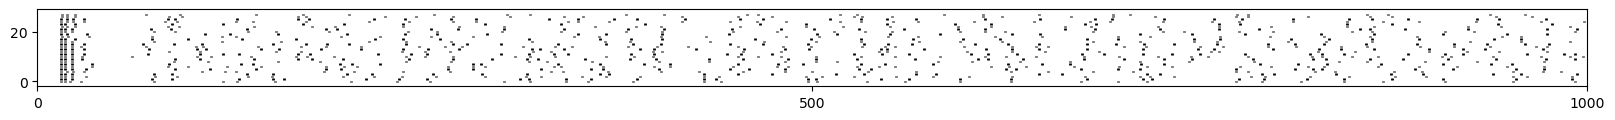

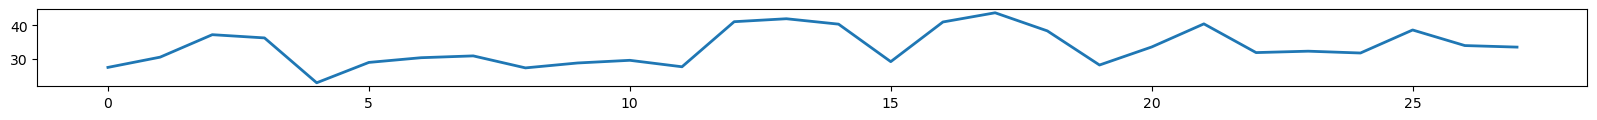

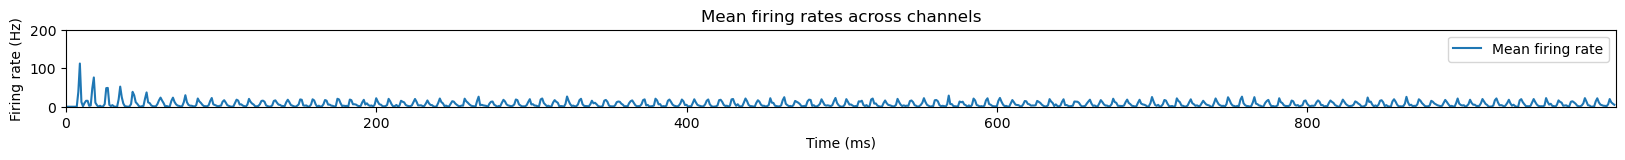

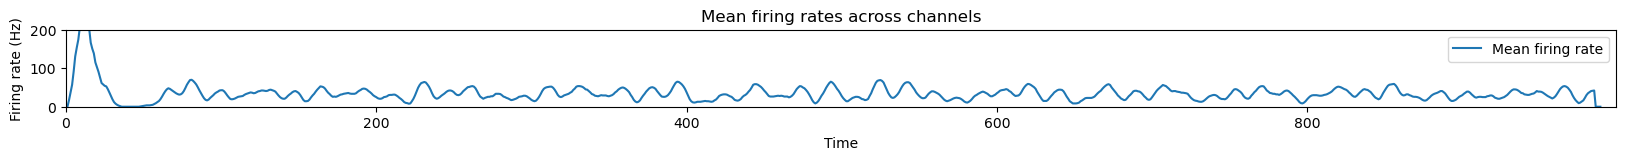

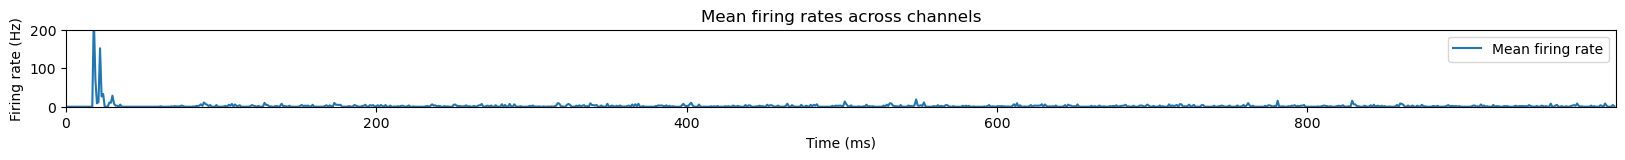

frequency:61 Hz    Mean Firing Rate(Hz): 33.45262908935547


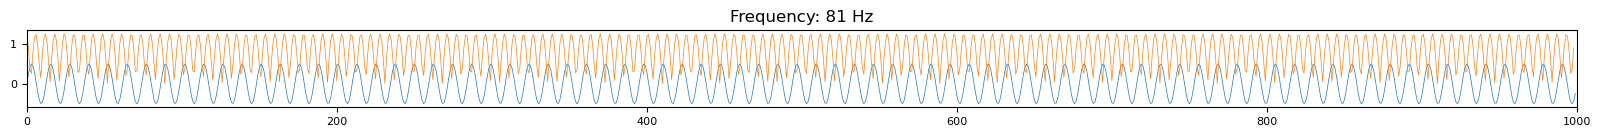

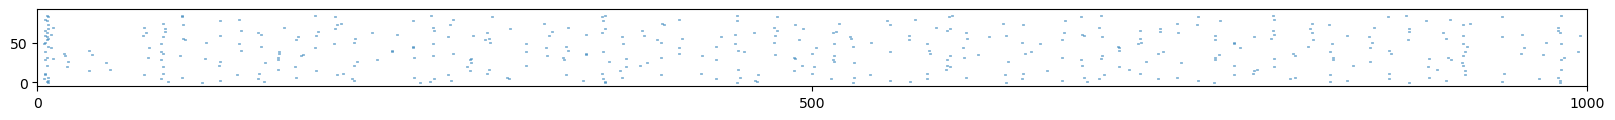

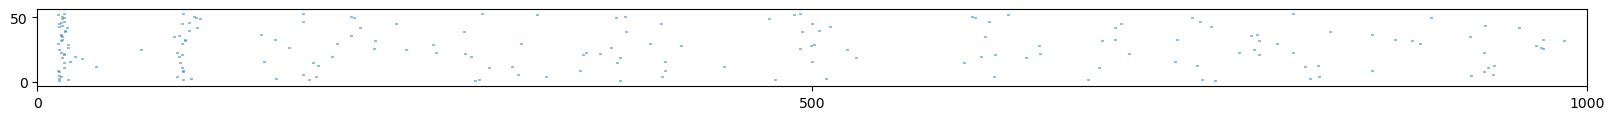

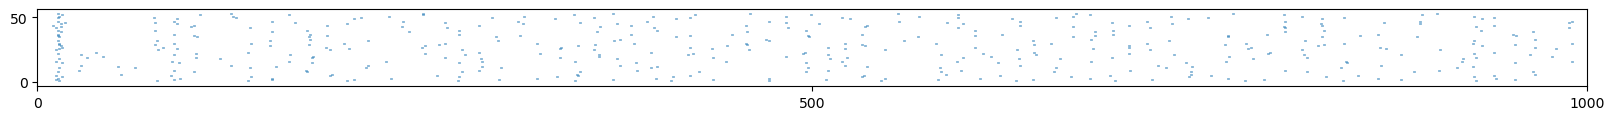

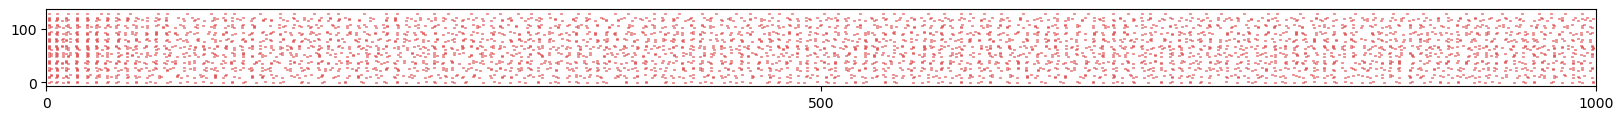

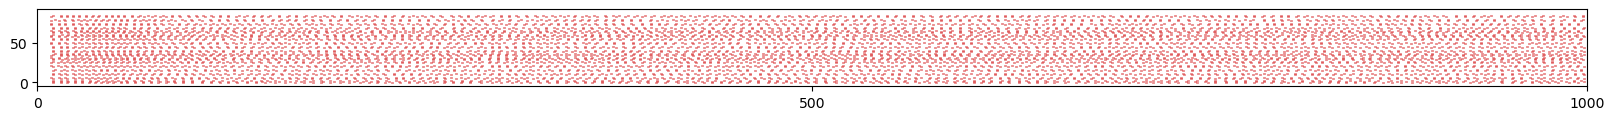

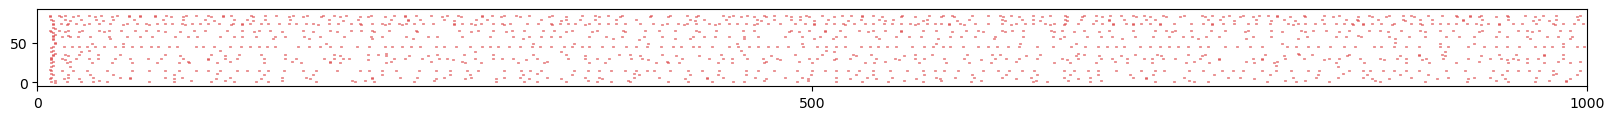

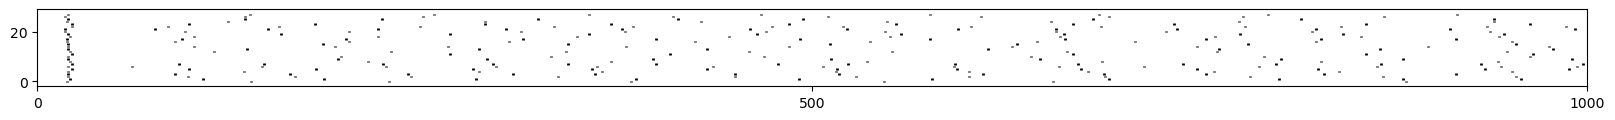

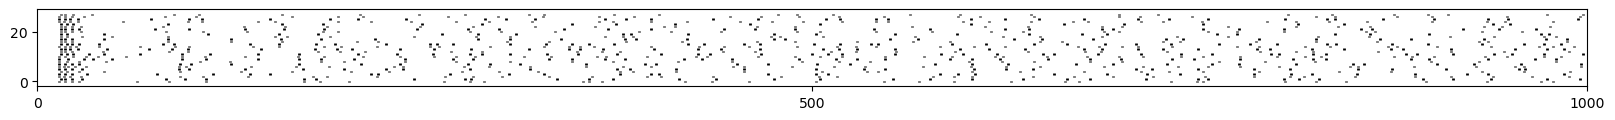

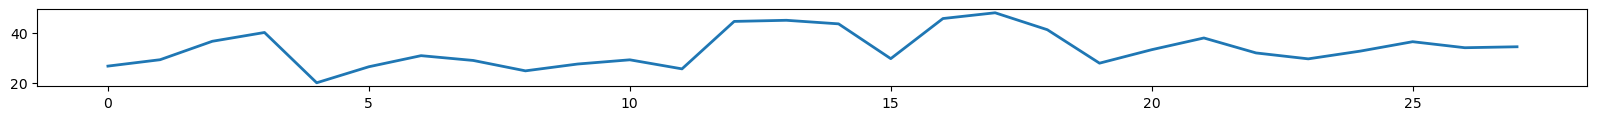

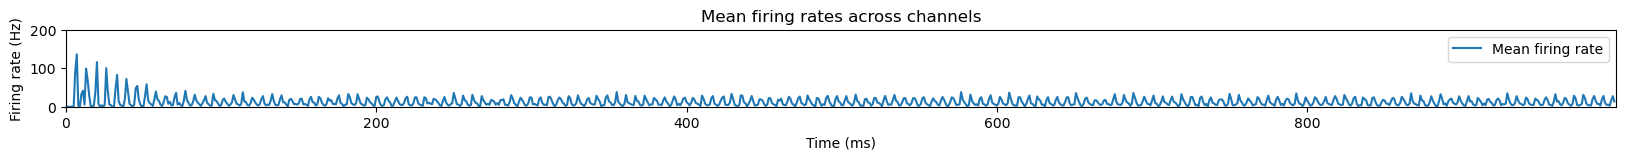

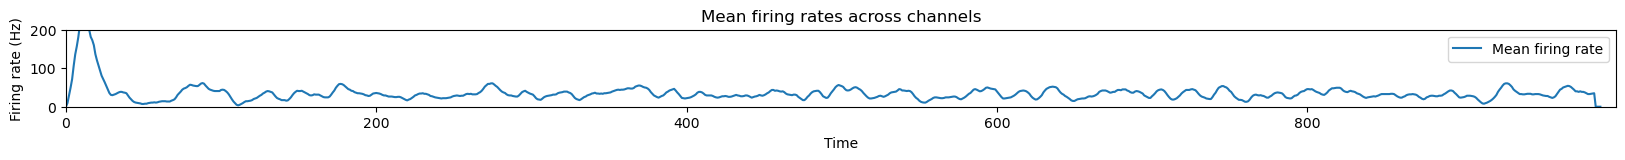

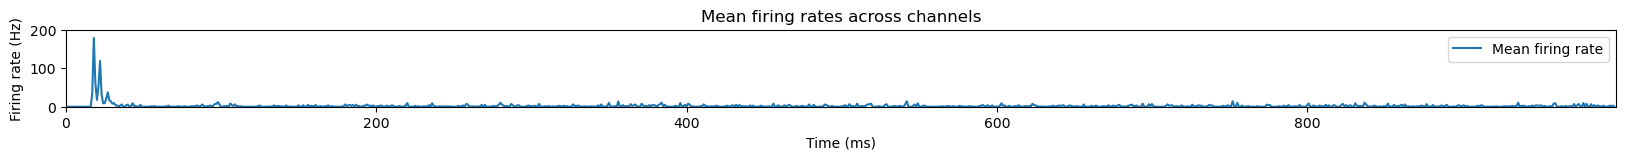

frequency:81 Hz    Mean Firing Rate(Hz): 33.651878356933594


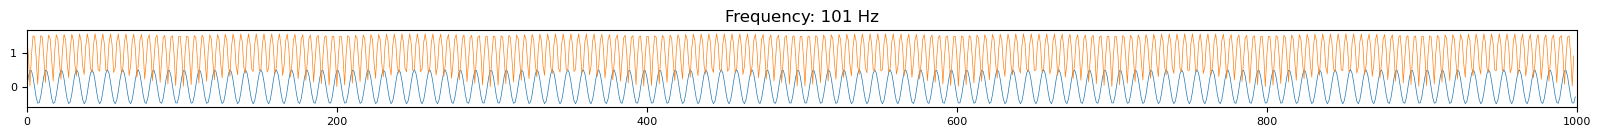

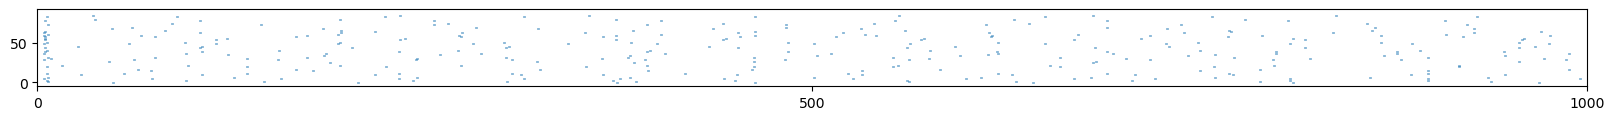

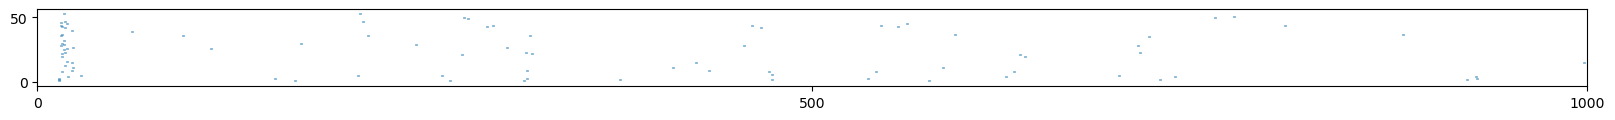

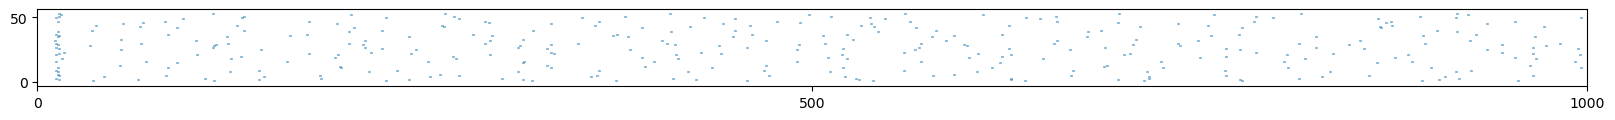

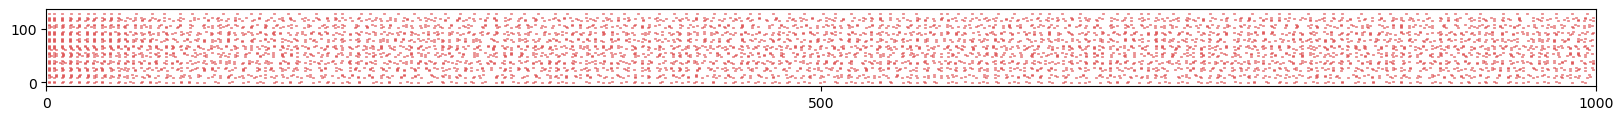

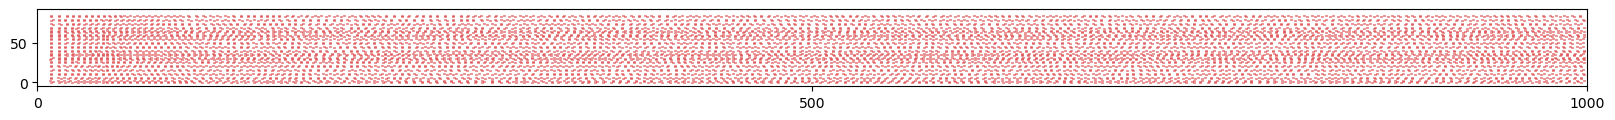

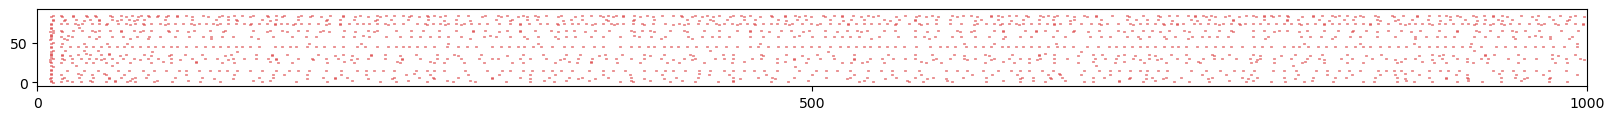

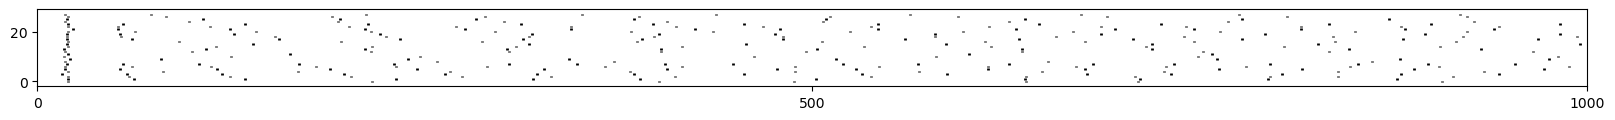

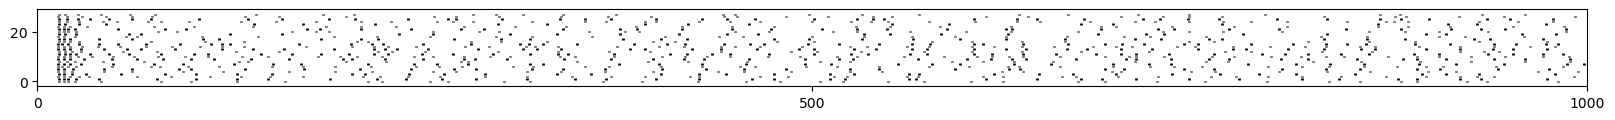

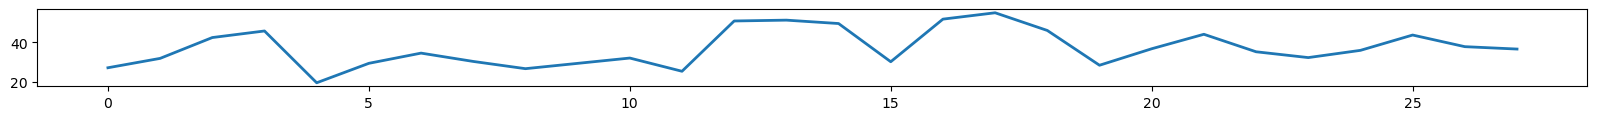

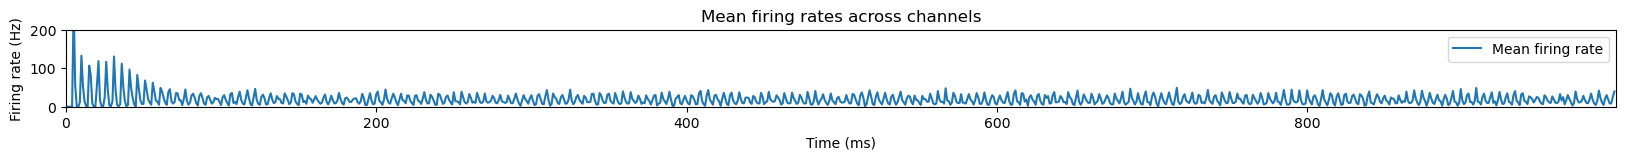

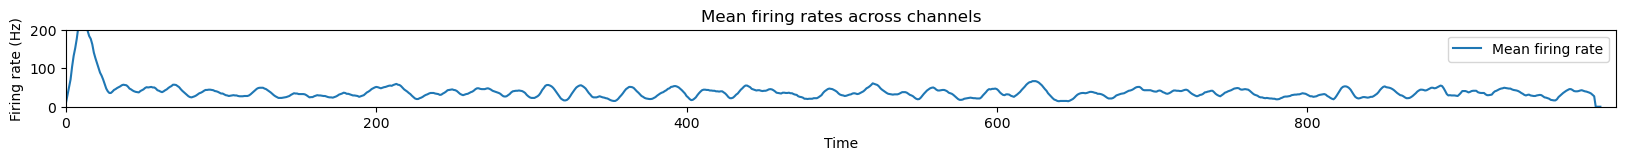

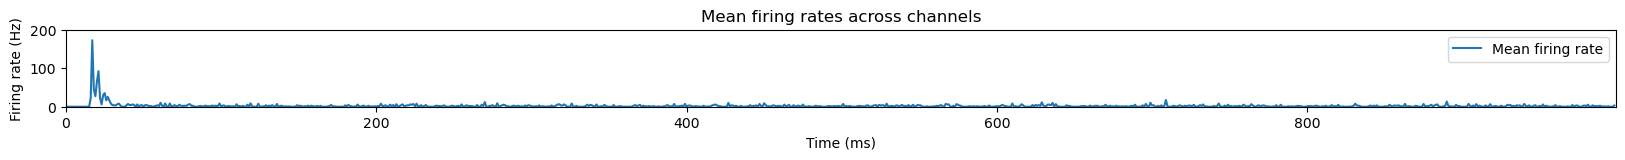

frequency:101 Hz    Mean Firing Rate(Hz): 37.136844635009766


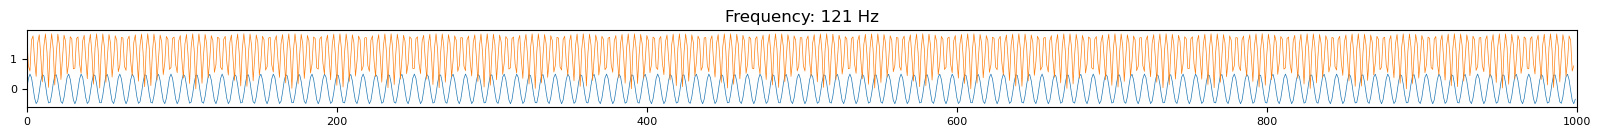

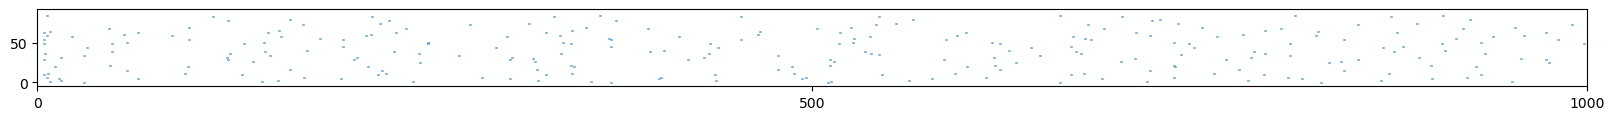

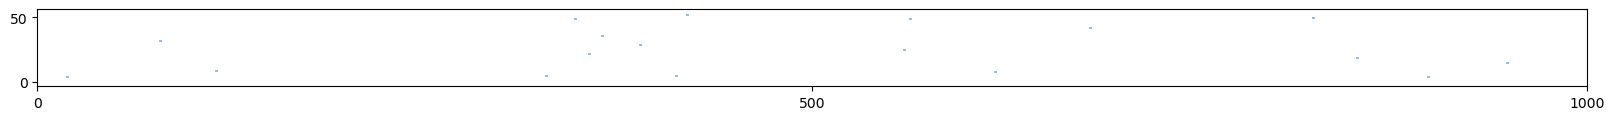

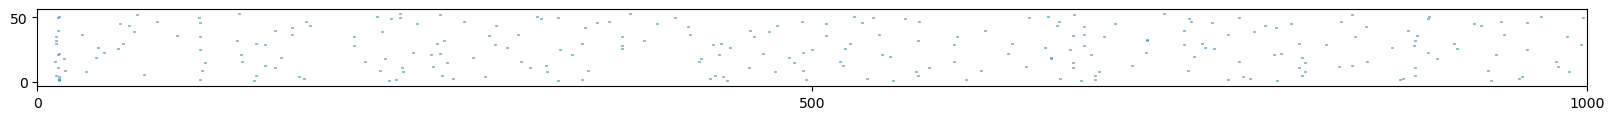

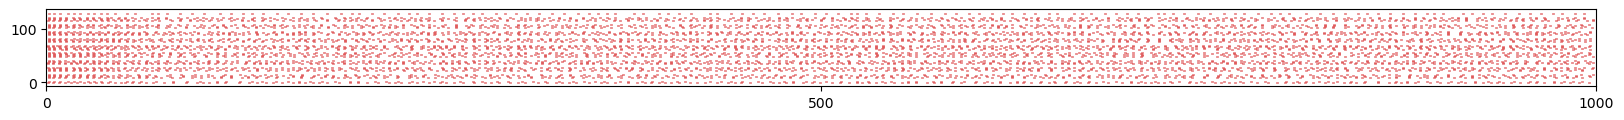

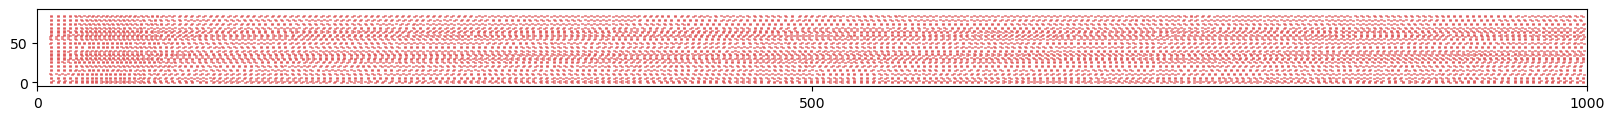

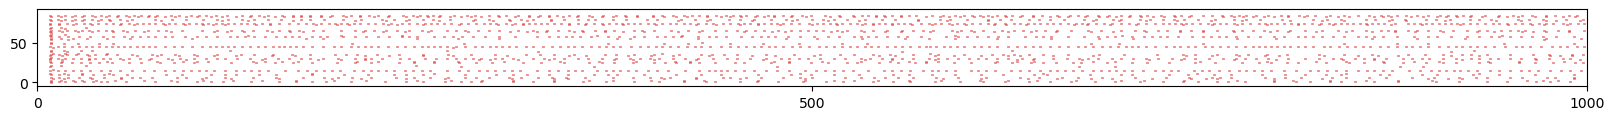

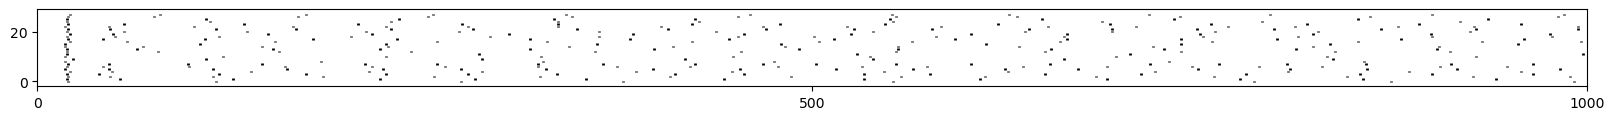

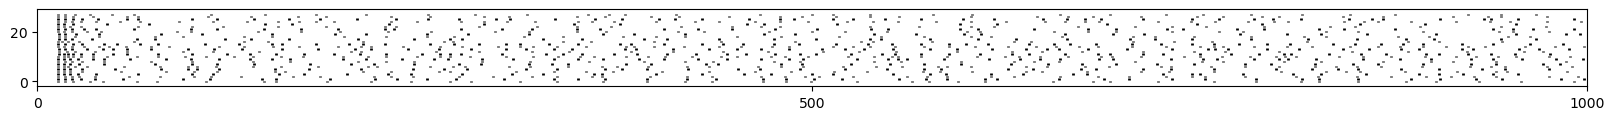

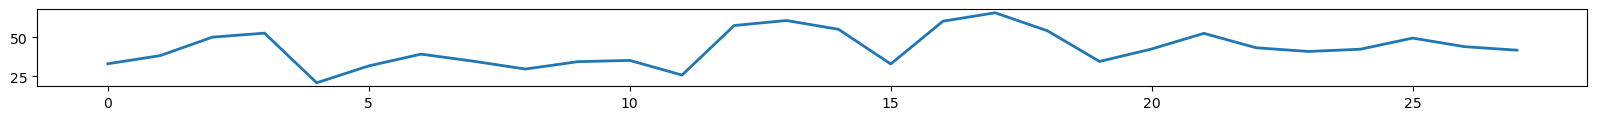

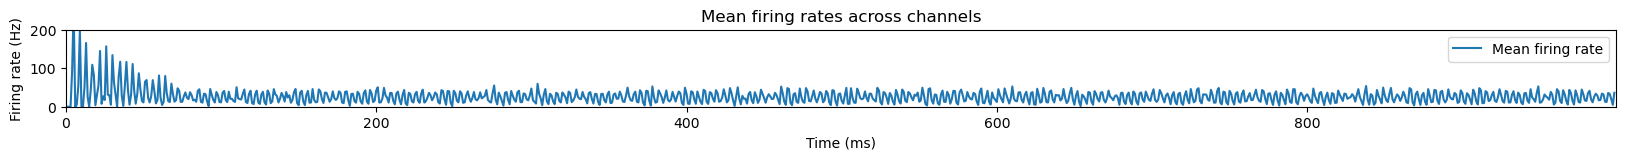

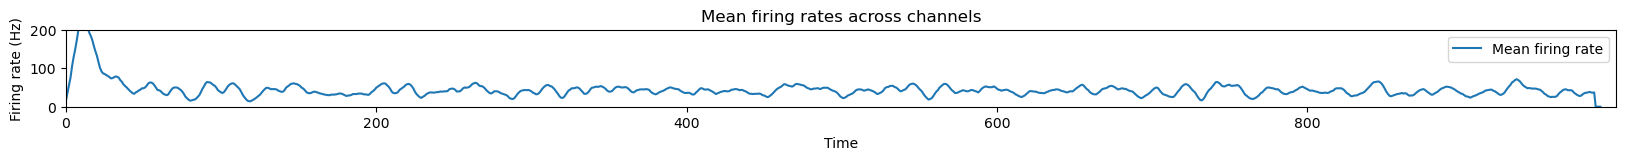

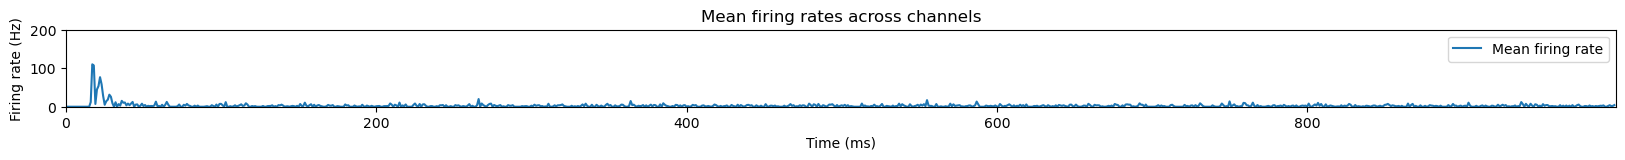

frequency:121 Hz    Mean Firing Rate(Hz): 43.012027740478516


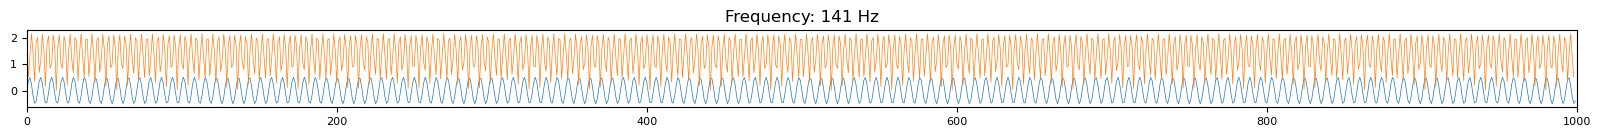

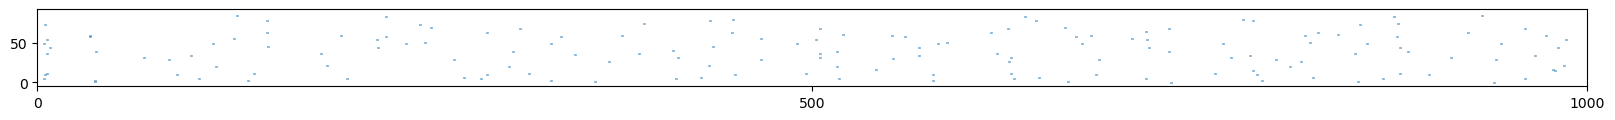

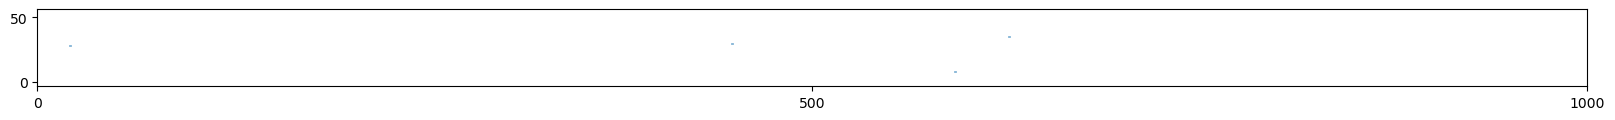

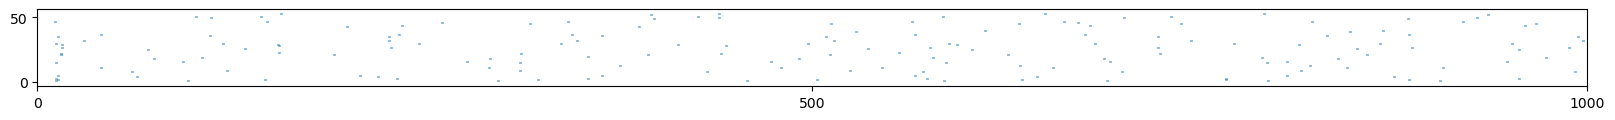

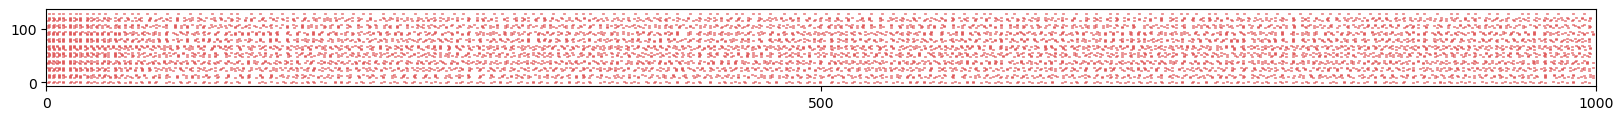

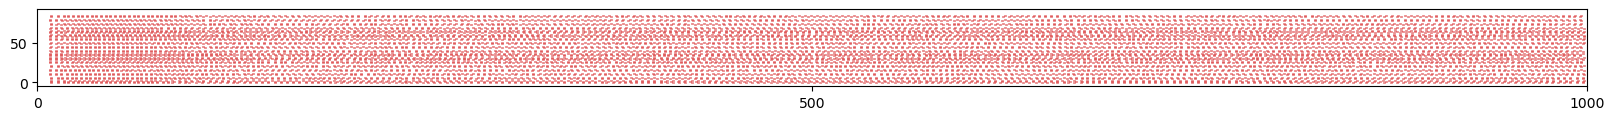

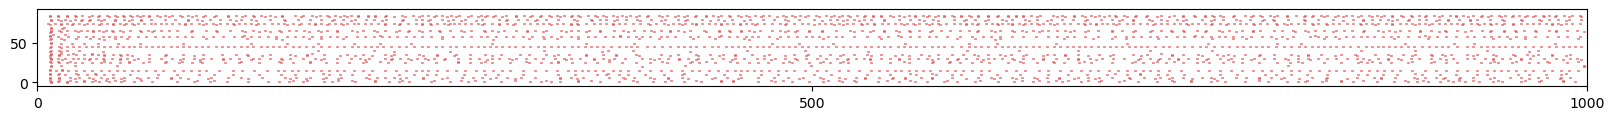

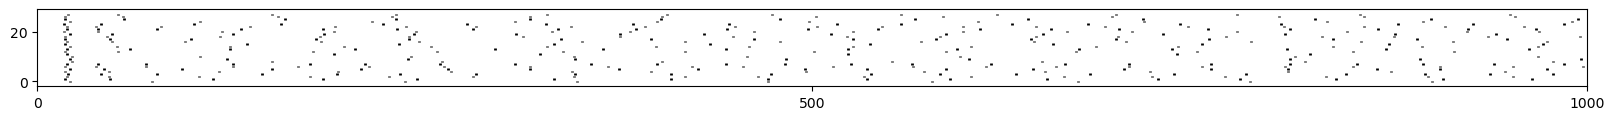

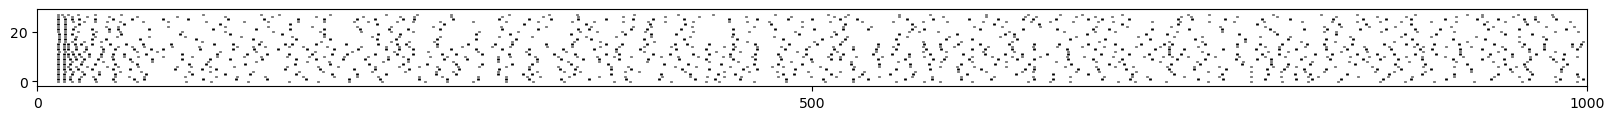

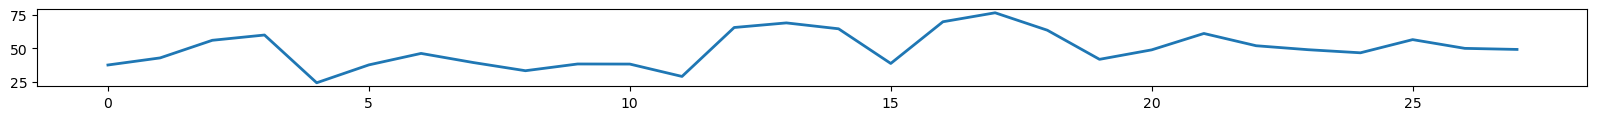

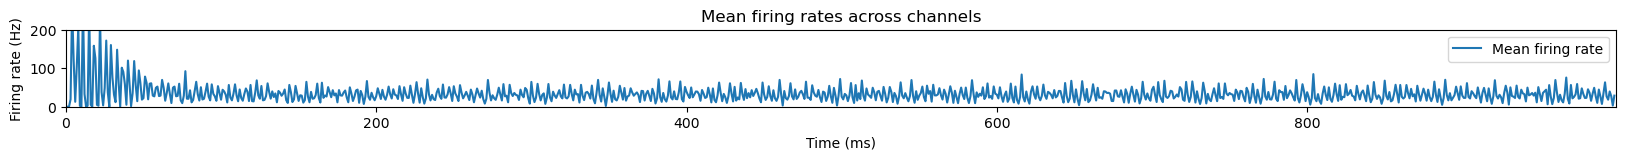

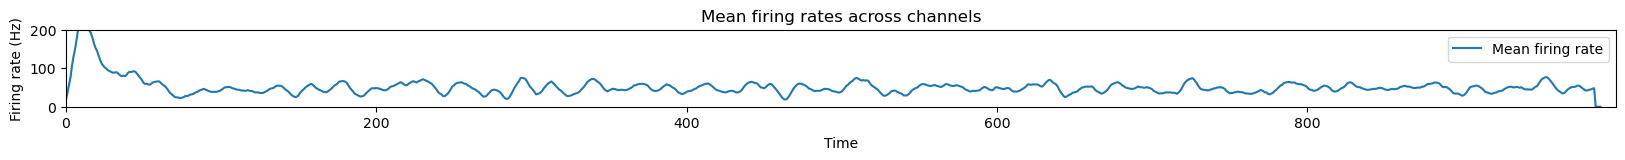

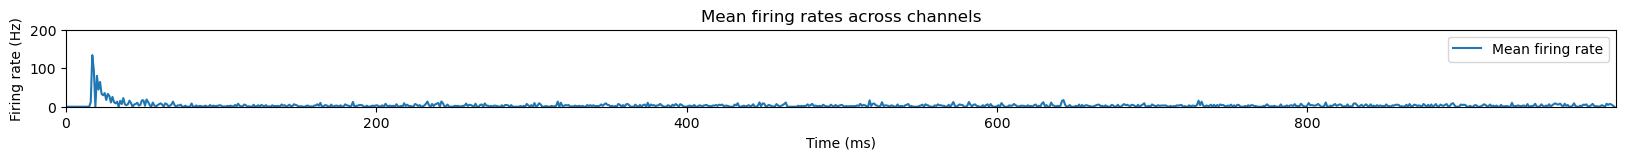

frequency:141 Hz    Mean Firing Rate(Hz): 49.52556228637695


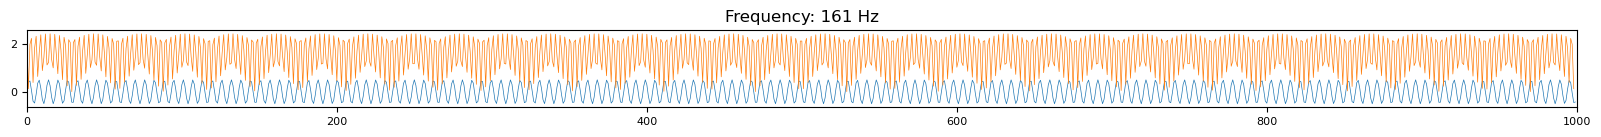

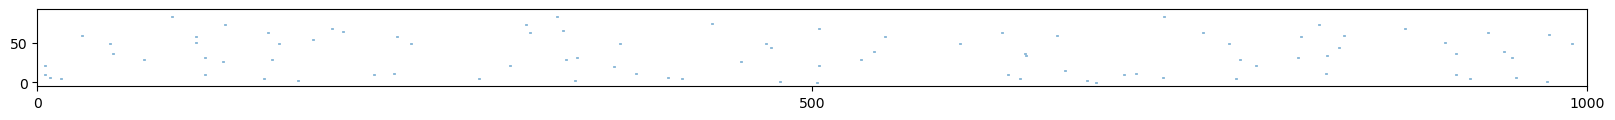

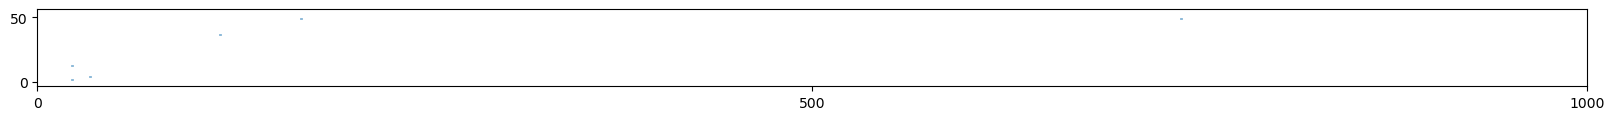

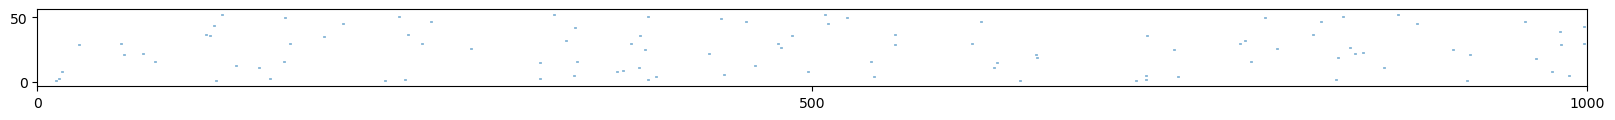

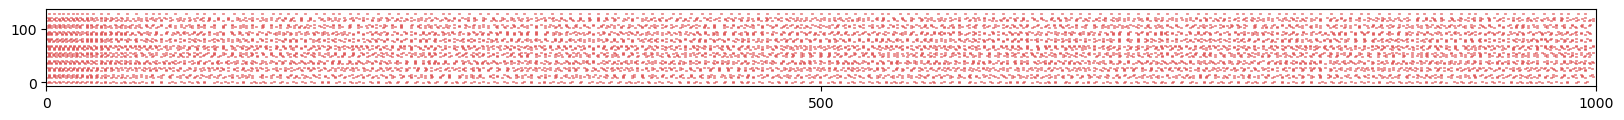

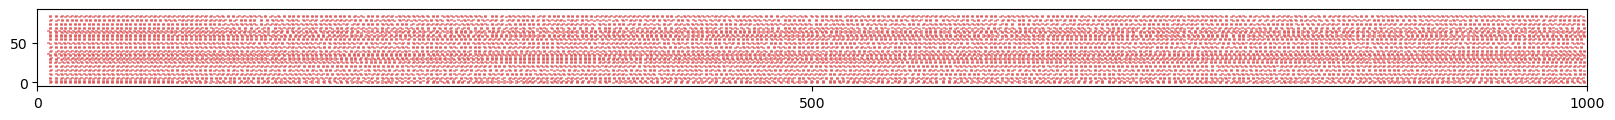

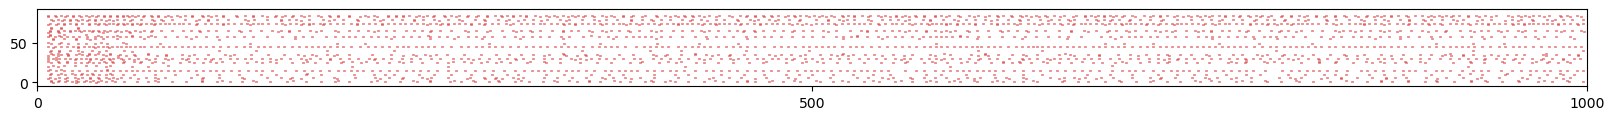

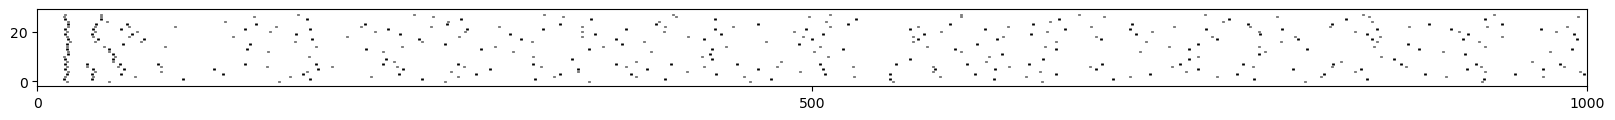

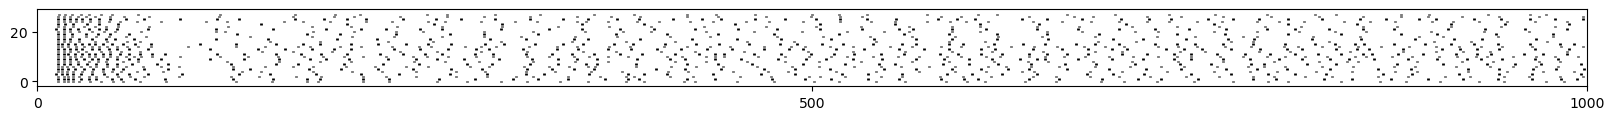

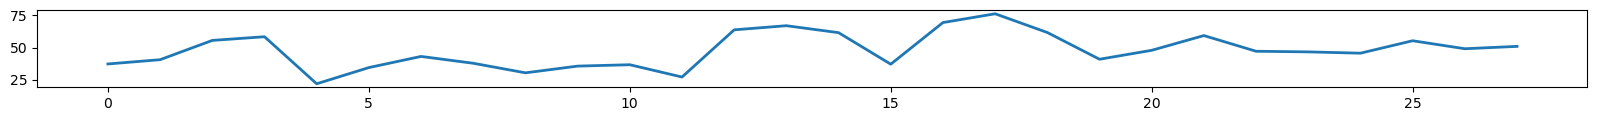

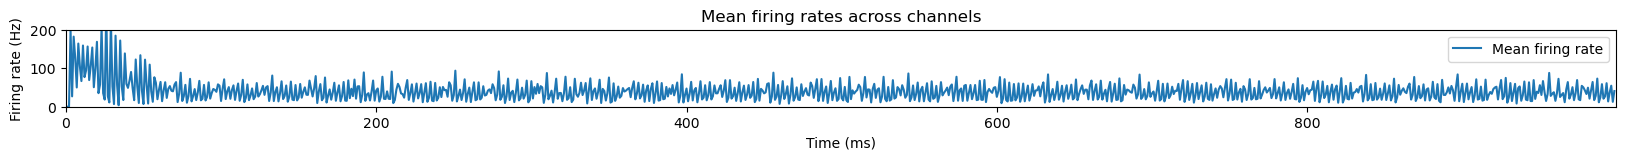

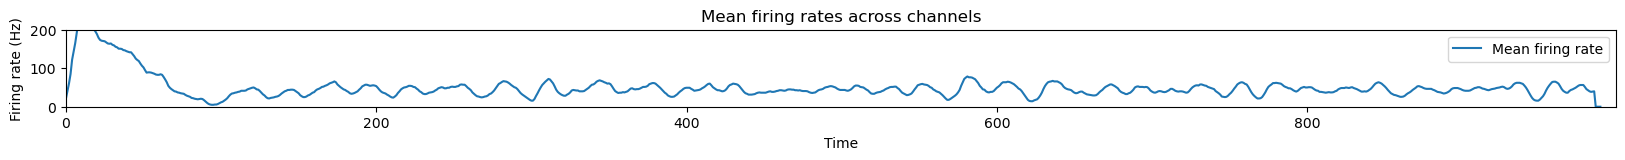

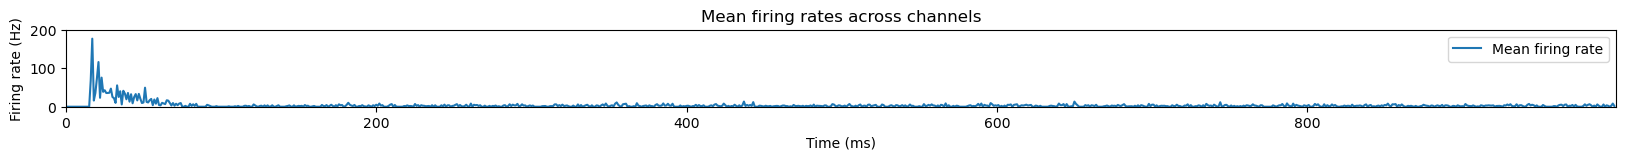

frequency:161 Hz    Mean Firing Rate(Hz): 47.86916732788086


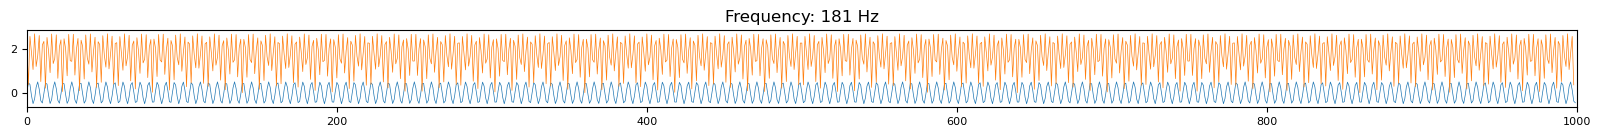

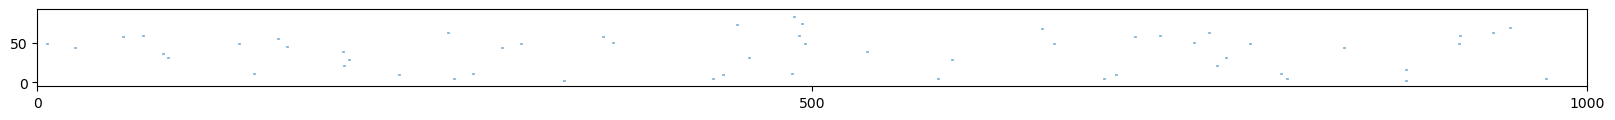

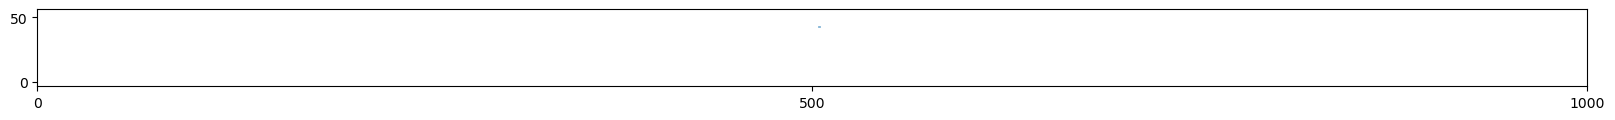

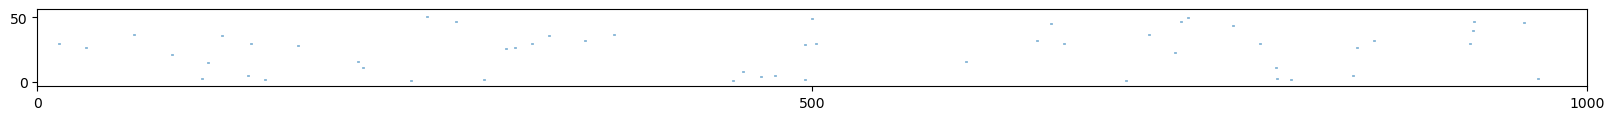

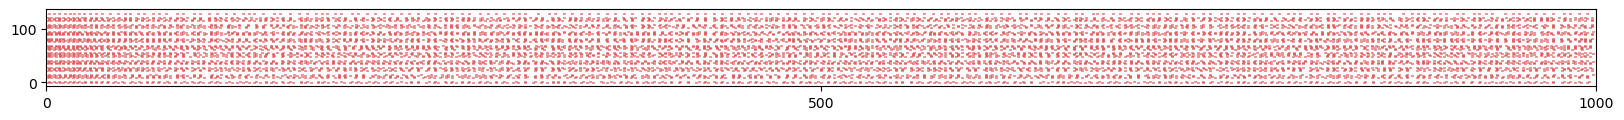

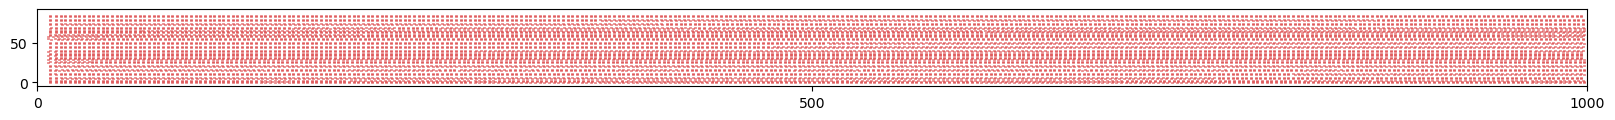

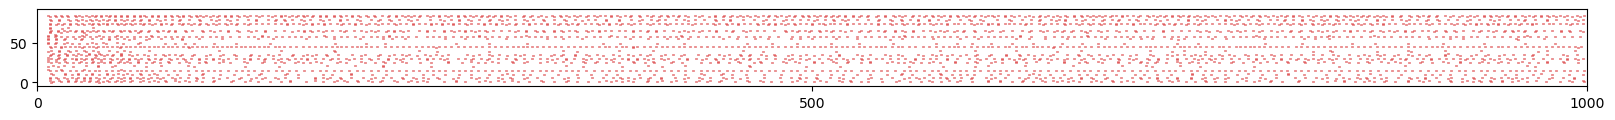

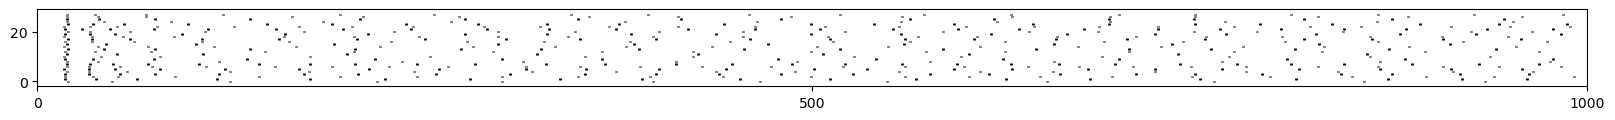

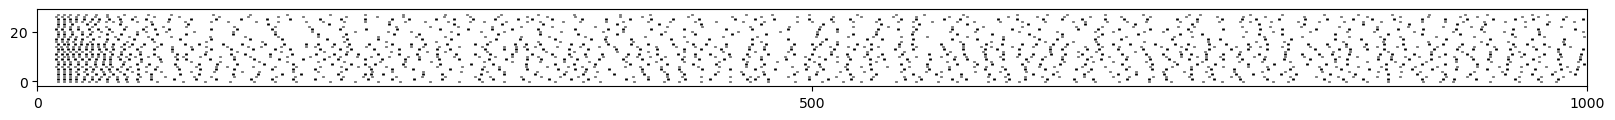

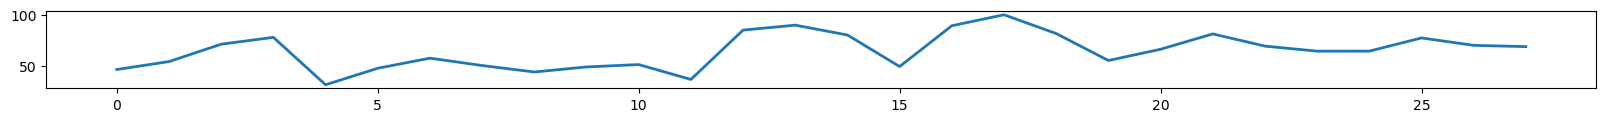

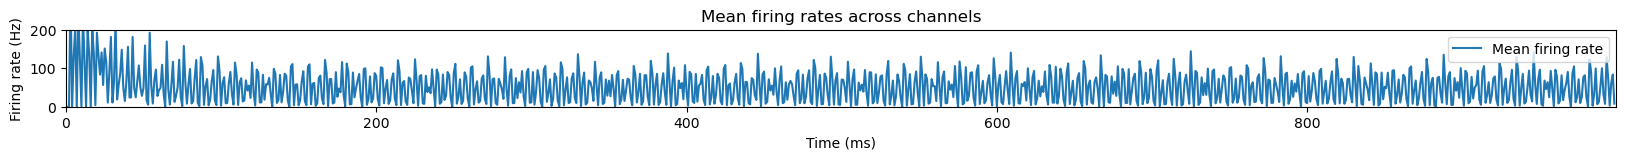

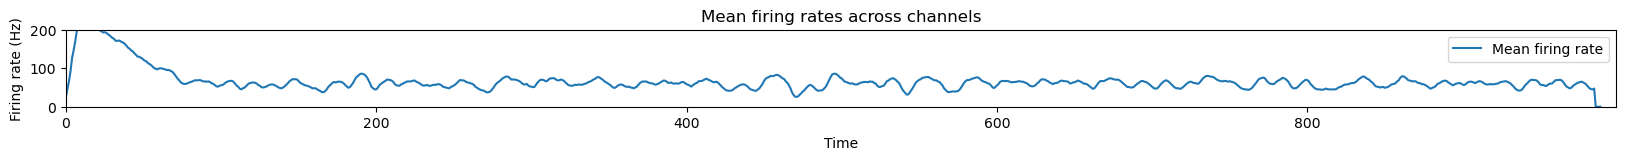

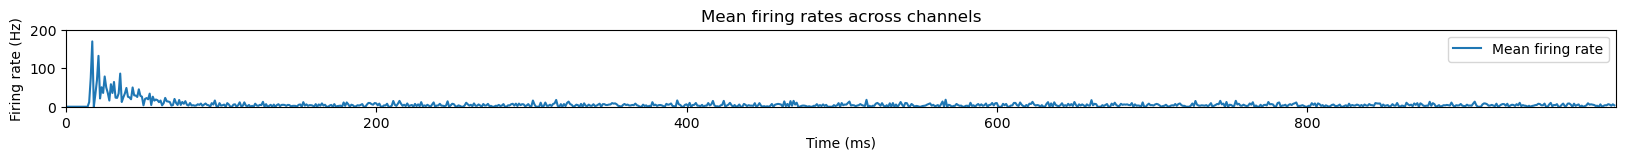

Trials: 100%|██████████| 1/1 [00:59<00:00, 59.14s/it]

frequency:181 Hz    Mean Firing Rate(Hz): 64.67068481445312


In [6]:
from tqdm import tqdm

num_trials = 1
num_frequencies = range(1,201, 20) # Frequencies from 80 to 100 with a step of 1
num_stim = 1000
F = 0.5 
pixel_h = 64
pixel_w = 48
device = 'cpu'  
data = []
labels = []

# Run the trials
for trial in tqdm(range(num_trials), desc="Trials"):
    # Generate the stimuli for each frequency
    for frequency in tqdm(num_frequencies, desc=f"Trial {trial+1} - Frequencies", leave=False):
        # Generate the stimulus
        plot_figure = (trial == 0)

        stimulus = generate_single_frequency_stimulation(frequency, num_stim=num_stim, pixel_h=pixel_h, pixel_w=pixel_w, F=F, plot_stimuli = plot_figure ,device=device)

        S = SNN(R, device = device, noise_std_val = 2, a_decay = 1.01)  # Update with your SNN initialization method
        S.feedforward(stimulus)
        
        mean_firing_rates = plot_SNN(S,layers = ['sa','ra','cn'],plot_figure = plot_figure,fig_size = (20,1))


        # if trial == 1:
        
        #     mean_firing_rates = plot_SNN(S,layers=['cn'],plot_figure = True,fig_size = (20,1))
        plot_isi_firing_rates(S.ra_spike_times[0],  fig_size = (20,1), plot_figure = plot_figure)
        plot_mean_firing_rates(S.cn_spike_times[1], bin_size = 10,  fig_size = (20,1), plot_figure = plot_figure)
        plot_isi_firing_rates(S.cn_spike_times[1],  fig_size = (20,1), plot_figure = plot_figure)
        if trial == 0:
            print('frequency:' + str(frequency) +' Hz   ' + ' Mean Firing Rate(Hz): ' + str(torch.mean(mean_firing_rates).item()))

        # Save the data and labels
        data.append(mean_firing_rates.cpu().numpy())
        labels.append(frequency)


In [2]:
# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

np.save('data_svm_angle.npy', data)
np.save('labels_svm_angle.npy', labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Create and train the SVM
clf = svm.SVC(kernel='linear')  # You can change the kernel as needed
clf.fit(X_train, y_train)

# Test the SVM
y_pred = clf.predict(X_test)

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# print(X_train.shape)
# print(X_test.shape)
# print(y_train)
# print(y_test)

# Identify the misclassified samples
misclassified = np.where(y_test != y_pred)

# Print the misclassified labels
print("Misclassified labels               : ", y_test[misclassified])
print("Test output of misclassified labels: ", y_pred[misclassified])
# Print the indices of the misclassified samples
# print("Indices of misclassified samples: ", misclassified)

# Calculate mean and standard deviation across trials
mean_data = np.mean(data, axis=1) 
std_data = np.std(data, axis=1)
unique_frequencies = np.unique(labels)

# Create a new figure with a specific size (to make it square)
plt.figure(figsize=(6, 6))

# Create an array of x values (which are just the indices)
x_values = range(len(unique_frequencies))

# The y values are the frequencies themselves
y_values = unique_frequencies

# Create a subplot for the x=y line
plt.subplot(1, 1, 1)  # The figure has 1 row, 1 column, and this is the 1st plot.
plt.plot(x_values, y_values, label='y=x', color='red', linestyle='--')  # make the line red and dashed
plt.xlabel('Index')
plt.ylabel('Frequency')

# Create a bar plot for each frequency
for i, frequency in enumerate(unique_frequencies):
    plt.bar(i, mean_data[i], yerr=std_data[i], capsize=5, color='lightgray')  # Change color to less vibrant

# Set the x-ticks to be the frequencies
plt.xticks(range(len(unique_frequencies)), unique_frequencies)

# Show the plot
plt.show()

NameError: name 'data' is not defined

In [26]:
import pickle

# 묶어서 저장할 데이터를 dictionary 형태로 정리
save_data = {"data": data, "labels": labels}

# 파일을 쓰기모드('wb')로 열고 pickle.dump 함수로 데이터를 저장
with open('data_labels.pkl', 'wb') as f:
    pickle.dump(save_data, f)